# Analysis of Olympic Data from 1896 to 2022

## 1. Introduction

This projects focuses on analysing Olympic Games data from 1896 to 2022. It covers both summer and winter games during that time frame.
The aim is to showcase various metrics including;

* Medal Analysis - Which countries are the historic performers?
* Year by Year Analysis - There is a rich history of the games. How does this look over the past 120+ years
* Athlete Analysis - Who are the top performers? What characteristics do top athletes possess?

## 2. Data Set-up



In [1]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pwd

'C:\\Users\\roger\\OneDrive\\Documents\\GitHub\\OlympicDataAnalysis'

In [3]:
## FILE INFORMATION

filename_master_path = './UCDAssessmentData/120 Years of Olympic History/athlete_events.csv'
filename_additional_path = './UCDAssessmentData/Olympic Summer & Winter Games - 86 to 22/olympic_results.csv'
filename_additional_athlete_path = './UCDAssessmentData/Olympic Summer & Winter Games - 86 to 22/olympic_athletes.csv'

In [4]:
## Load the master data file. This contains Olympic Game information from 1896 through to 2016
master_data = pd.read_csv(filename_master_path)

# Clean the master_data file
master_data = master_data.drop(["ID","Games"],axis=1)


In [5]:
## Load the additional (add) data that contains Summer and Winter game information upto and including Beijing 2022
add_data = pd.read_csv(filename_additional_path)

# Remove columns that are not needed.
add_data = add_data.drop(["rank_equal","rank_position","value_unit","value_type"],axis=1)

# Create an Event column by merging discipline and event title 
add_data["Event"] = add_data["discipline_title"] + ' ' + add_data["event_title"]

# To match the master file, venue and year need to be split out. There are entries like "salt-lake-city" in the data-set so using rsplit to get the last entry.
add_data[['Venue','Year']] = add_data['slug_game'].str.rsplit('-',1,expand=True)

# Converting the Year column to integer so filtering can be performed on it
add_data['Year'] = add_data['Year'].astype(int)

# Filter out all records earlier and including 2016. These should already be in master set

print("The number of rows pre-filtering is: ", add_data.shape[0])
add_data = add_data[(add_data['Year'] > 2016)]
print("The number of rows post-filtering is: ", add_data.shape[0])



The number of rows pre-filtering is:  162804
The number of rows post-filtering is:  14354


In [6]:
# Creating a new dataframe that will contain individual medal winners where they are currently assigned to only a line
new_data = pd.DataFrame(columns=add_data.columns)

# Setting index counter
new_ind = 0

# Set expression to search for. Regular expression was cleaner than searching for text
expression = re.compile('\'[^\']*\'')

# This loops through the new data set and finds instances where there are teams of two. It will then update the athlete_full_name and athlete_url for the first entry
# The second entry gets updated in the new dataframe and appended on at the end.
for ind in add_data.index :
    
    # Search for values where that are not null
    if pd.notnull(add_data["athletes"][ind]) :
    
        #Might be able to merge these
        cell_val = add_data["athletes"][ind]
        list_val = expression.findall(cell_val)
                
        if len(list_val) == 4 :
            # Step 1: Set the Athlete Full Name + URL of this row to the first athlete in the list
            add_data.loc[ind,"athlete_full_name"] = list_val[0]
            add_data.loc[ind,"athlete_url"] = list_val[1]

            # Step 2: Set the Athlete Full Name + URL to a new row which is copy of the one above. 
            #This will be specific though to the second athlete
            new_data.loc[new_ind] = add_data.iloc[ind]
            new_data.loc[new_ind,"athlete_full_name"] = list_val[2]
            new_data.loc[new_ind,"athlete_url"] = list_val[3]
            new_ind+=1
       
        elif len(list_val) == 2 :
            
            # In this instance there will be two athletes but the URL may not be available.
            # Step 3: Set the Athlete Full Name + URL of this row to the first athlete in the list
            add_data.loc[ind,"athlete_full_name"] = list_val[0]
            
            # Step 4: Set the Athlete Full Name + URL to a new row which is copy of the one above. 
            #This will be specific though to the second athlete
            new_data.loc[new_ind] = add_data.iloc[ind]
            new_data.loc[new_ind,"athlete_full_name"] = list_val[1]
            new_ind+=1
            
        elif len(list_val) == 3 :
            #In this instance, there could be URL missing for one or other of the participants
            #Assumption: 1st value will always be a name
        
            # Step 5: Set the Athlete Full Name + URL of this row to the first athlete in the list
            add_data.loc[ind,"athlete_full_name"] = list_val[0]
            if list_val[1].startswith("\'https") and (list_val[0].find(',') == -1)  :
                add_data.loc[ind,"athlete_url"] = list_val[1]              
                new_data.loc[new_ind] = add_data.iloc[ind]
                new_data.loc[new_ind,"athlete_full_name"] = list_val[2]
            
            elif list_val[1].startswith("\'https") == False and (list_val[0].find(',') == -1) :
                new_data.loc[new_ind] = add_data.iloc[ind]
                new_data.loc[new_ind,"athlete_full_name"] = list_val[1]
                new_data.loc[new_ind,"athlete_url"] = list_val[2]
            
            else :
                print("Some data could not be processed.",add_data["athletes"][ind])
                        
            new_ind+=1
            
        else:
            print("There has been an error or there are more team athletes than 2")    
            

Some data could not be processed. [("Tuva'a CLIFTON", 'https://olympics.com/en/athletes/tuva-a-clifton'), ('Rudolf BERKING-WILLIAMS', 'https://olympics.com/en/athletes/rudolf-berking-williams')]


<b>NOTE: </b>There is one record that does not get processed correctly. This is as a result of issues with the regular expression used. Unfortunately it was not possible to fully resolve this before submission.

In [7]:
# Concatenate the existing information with the new data
add_data = pd.concat([add_data,new_data],axis=0)

In [8]:
#In the master set they differentiate winter / summer
venue_season_dict = {
    'Year' : [2018,2020,2022],
    'Season' : ['Winter','Summer','Winter'],
    'City' : ['Pyeongchang','Tokyo','Beijing'],
}

supp_info = pd.DataFrame(venue_season_dict)

add_data = add_data.merge(supp_info, on='Year', how='left')

In [9]:
# Create a column to determine the sex of the athletes. This will be based on the events column
for ind in add_data.index :
    
    # Search for values where that are not null
    if pd.notnull(add_data["Event"][ind]) :
           
        if add_data["Event"][ind].lower().find(" men") >= 0:
            add_data.loc[ind,"Sex"] = "M"            
        elif add_data["Event"][ind].lower().find(" women") >= 0:
            add_data.loc[ind,"Sex"] = "F"
        else:
            add_data.loc[ind,"Sex"] = ""
        

In [10]:
#Bring in specific athlete data - specifically the birth year of the athlete
add_data_athlete = pd.read_csv(filename_additional_athlete_path)

In [11]:
#Remove columns that are not needed during further analysis.
add_data_athlete = add_data_athlete.drop(["athlete_url","games_participations","first_game","athlete_medals","bio"],axis=1)

In [12]:
# Merge the specific data on the athletes with the additional data already set-up. The aim here is to match athlete with age
add_data = add_data.merge(add_data_athlete, on='athlete_full_name', how='left')

In [13]:
# Create a column to determine the age of the athletes. This will be based on the olympics year and athlete birth year column.
# Given only birth year is available, this calculation will be an approximation only

for ind in add_data.index :
    
    # Search for values where that are not null
    if pd.notnull(add_data["athlete_year_birth"][ind]) :
        add_data.loc[ind,"Age"] = add_data.loc[ind,"Year"] - add_data.loc[ind,"athlete_year_birth"]
        

In [14]:
## Set up the additional data to more closely match the master set

#Remove unnecessary columns
add_data = add_data.drop(["event_title","slug_game","participant_type","athletes","country_code","athlete_url","athlete_year_birth","Venue"],axis=1)

#Rename columns to ensure consistency
add_data = add_data.rename(columns = {'medal_type':'Medal','country_name':'Team','country_3_letter_code':'NOC','athlete_full_name':'Name','discipline_title':'Sport'})

#Reindex for future analysis
add_data = add_data.reindex(columns=["Name","Sex","Age","Team","NOC","Year","Season","City","Sport","Event","Medal",])

In [15]:
#Ensure that the master data set up is correspondingly set-up
master_data = master_data.reindex(columns=["Name","Sex","Age","Team","NOC","Year","Season","City","Sport","Event","Medal","Height","Weight"])

In [16]:
## Concatenate the master and additional data sets to create a set from 1896 upto 2022
finalised_data_set = pd.concat([master_data,add_data],axis=0)

finalised_data_set = finalised_data_set.reset_index(drop=True)

In [17]:
# Continue to tidy up the finalised set post the concatenation with additional data set

finalised_data_set["Medal"] = finalised_data_set["Medal"].str.upper()
finalised_data_set["Name"] = finalised_data_set["Name"].str.replace("'","")
finalised_data_set["Name"] = finalised_data_set["Name"].str.upper()

In [18]:
sports_dictionary = {
    'Basketball':'Basketball', 'Judo':'Martial Arts', 'Football':'Football', 'Tug-Of-War':'Tug-Of-War', 
    'Speed Skating':'Skating', 'Cross Country Skiing':'Skiing', 'Athletics':'Athletics', 'Ice Hockey':'Ice Hockey', 
    'Swimming':'Swimming', 'Badminton':'Badminton', 'Sailing':'Sailing', 'Biathlon':'Biathlon', 'Gymnastics':'Gymnastics',
    'Art Competitions':'Art Competitions', 'Alpine Skiing':'Skiing', 'Handball':'Handball', 'Weightlifting':'Weightlifting',
    'Wrestling':'Wrestling', 'Luge':'Luge', 'Water Polo':'Water Polo', 'Hockey':'Hockey', 'Rowing':'Rowing', 
    'Bobsleigh':'Bobsleigh', 'Fencing':'Fencing', 'Equestrianism':'Equestrianism', 'Shooting':'Shooting', 'Boxing':'Boxing',
    'Taekwondo':'Martial Arts', 'Cycling':'Cycling', 'Diving':'Diving', 'Canoeing':'Canoeing', 'Tennis':'Tennis',
    'Modern Pentathlon':'Modern Pentathlon', 'Figure Skating':'Skating', 'Golf':'Golf', 'Softball':'Baseball/Softball',
    'Archery':'Archery', 'Volleyball':'Volleyball', 'Synchronized Swimming':'Swimming', 'Table Tennis':'Table Tennis',
    'Nordic Combined':'Nordic Combined', 'Baseball':'Baseball/Softball', 'Rhythmic Gymnastics':'Gymnastics',
    'Freestyle Skiing':'Skiing', 'Rugby Sevens':'Rugby', 'Trampolining':'Trampolining', 'Beach Volleyball':'Beach Volleyball',
    'Triathlon':'Triathlon', 'Ski Jumping':'Ski Jumping', 'Curling':'Curling', 'Snowboarding':'Snowboarding', 'Rugby':'Rugby',
    'Short Track Speed Skating':'Skating', 'Skeleton':'Skeleton', 'Lacrosse':'Lacrosse', 'Polo':'Polo', 'Cricket':'Cricket',
    'Racquets':'Racquets', 'Motorboating':'Motorboating', 'Military Ski Patrol':'Skiing', 'Croquet':'Croquet',
    'Jeu De Paume':'Jeu De Paume', 'Roque':'Roque', 'Alpinism':'Skiing', 'Basque Pelota':'Basque Pelota',
    'Aeronautics':'Aeronautics', 'Snowboard':'Snowboarding', 'Figure skating':'Skating', 'Speed skating':'Skating',
    'Canoe Sprint':'Canoeing', 'Cycling Road':'Cycling', 'Artistic Swimming':'Swimming', 'Cycling BMX Racing':'Cycling',
    'Surfing':'Surfing', 'Canoe Slalom':'Canoeing', 'Marathon Swimming':'Swimming', 'Trampoline Gymnastics':'Trampolining',
    'Cycling Track':'Cycling', 'Sport Climbing':'Sport Climbing', 'Artistic Gymnastics':'Gymnastics',
    'Cycling BMX Freestyle':'Cycling', 'Skateboarding':'Skateboarding', 'Baseball/Softball':'Baseball/Softball',
    'Equestrian':'Equestrianism', 'Cycling Mountain Bike':'Cycling', 'Karate':'Martial Arts', '3x3 Basketball':'Basketball', 
    'Short Track':'Skating'
 }

finalised_data_set["Sport"] = finalised_data_set["Sport"].map(sports_dictionary, na_action=None)

## 3. Data Analysis & Visualisation

Following all the previous actions, a comprehensive data set is now available to use to perform further analysis on. In the next section, I delve in to specific areas.

In [19]:
country_code_medals = finalised_data_set[['NOC','Medal','Season','Year','Sex']]

#missing_values_count = country_code_medals.isnull().sum()
#print("MISSING: \n", missing_values_count[0:5])

#Drop entries where no medals were won. These are individual placings of the athletes but not needed for medal analysis
country_code_medals = country_code_medals.dropna().reset_index()


### 3.1 - Medal Analysis

This section analyses medal wins and profiles the top countries and how they have performed overall. Please note that I am using NOC (National Olympic Committee) codes in the data. I chose to use these rather than full country names as I think it makes the graphs easier to read. Details on the codes can be found at the following link - https://en.wikipedia.org/wiki/List_of_IOC_country_codes

In [20]:
# Calculate and group medals of the different types

country_code_medals_ind = country_code_medals.groupby(['NOC','Medal'])['Medal'].count().unstack().fillna(0)
country_code_medals_ind = country_code_medals_ind[["GOLD","SILVER","BRONZE"]].sort_values(by=["GOLD"], ascending=False).head(20)

In [21]:
## This function has been created to support the creation of bar charts. 
## Some of the process was repeated across different data points so it made sense to set-up in a function.
## The code is similar so this helps support DRY (Dont Repeat Yourself)

def function_graph_helper(dataframe, column_val, column_list, num_val):
    
    new_dataframe = dataframe.copy()
    new_dataframe[column_val] = new_dataframe.sum(axis=1)
    new_dataframe = new_dataframe.sort_values(by=[column_val], ascending=False).head(num_val)
    new_dataframe = new_dataframe[column_list]
    
    return new_dataframe

In [22]:
## Calculate the total medals per country

country_code_medals_totals = country_code_medals_ind.copy()
country_code_medals_totals = function_graph_helper(country_code_medals_totals, "TOTAL", "TOTAL", 20)

In [23]:
## Calculate medal counts by season; winter or summer. Given plot size this is top 15 countries

country_code_medals_season = country_code_medals.groupby(['NOC','Season'])['Season'].count().unstack().fillna(0)
country_code_medals_season = function_graph_helper(country_code_medals_season, "TOTAL", ["Summer","Winter"], 15)

In [24]:
## Calculate medal counts by country by gender; male or female
country_code_medals_gender = country_code_medals.groupby(['NOC','Sex'])['Sex'].count().unstack().fillna(0)
country_code_medals_gender = function_graph_helper(country_code_medals_gender, "TOTAL", ["M","F"], 20)

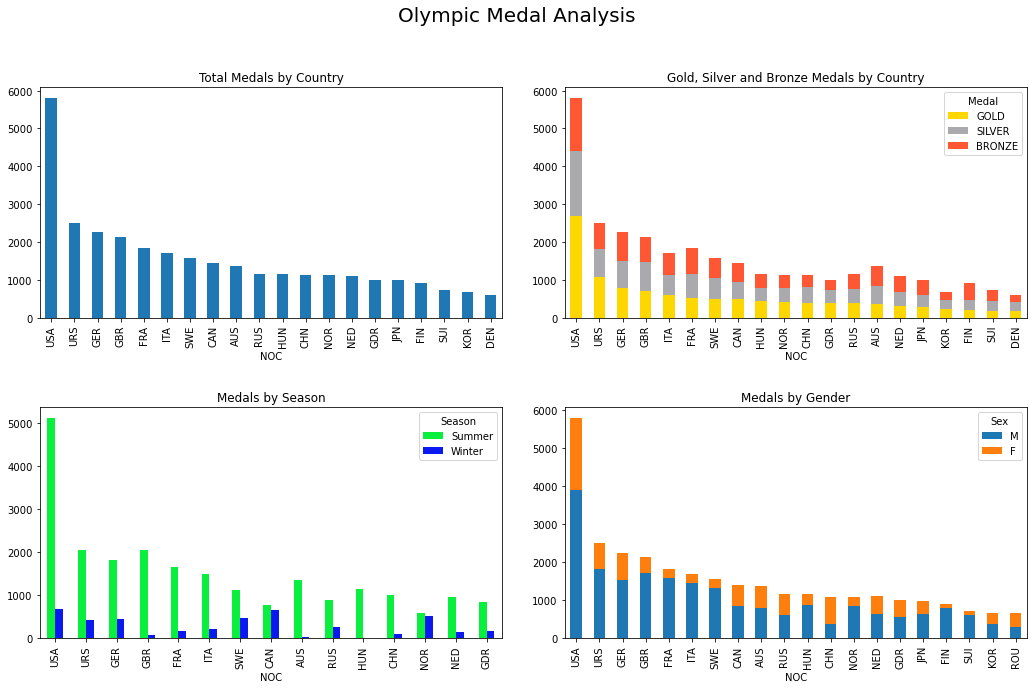

In [25]:
## Generate a 2 * 2 plot that can showcase the medal data side-by-side.
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False)

#Define a specific colour scheme for medals and seasons. Ones created for GOLD, SILVER, BRONZE, SUMMER, WINTER
mcolors = {
    'GOLD': '#FFD700',
    'SILVER': '#AAA9AD',
    'BRONZE': '#FF5733',
    'Summer': '#09EF3E',
    'Winter': '#0919EF'
}

fig.suptitle('Olympic Medal Analysis', fontsize=20)

# Plot Totals First
country_code_medals_totals.plot(ax=ax1, kind='bar', stacked=False, figsize=(15,10), title='Total Medals by Country',legend=False)

# Plot Medals
country_code_medals_ind.plot(ax=ax2, kind='bar', stacked=True, figsize=(15,10), title='Gold, Silver and Bronze Medals by Country', color=mcolors, legend=True)

#Plot Seasons
country_code_medals_season.plot(ax=ax3, kind='bar', stacked=False, figsize=(15,10), title='Medals by Season', color=mcolors, legend=True)

#Plot Gender
country_code_medals_gender.plot(ax=ax4, kind='bar', stacked=True, figsize=(15,10), title='Medals by Gender', legend=True)

# Space the plots out
fig.tight_layout(pad=3.0)

plt.show()

<b>INSIGHTS: </b> 

* USA is ahead in terms of total medal haul across Summer and Winter games
* The next nearest country to USA is URS (Soviet Union). Coincidentally, based on <u>this</u> data, the USA has more gold medals than the Soviet Union has total medals.
* GER (Germany) is fairly close to the Soviet Union in terms of medal wins.
* Canada performs well at both Summer and Winter games. Its worth noting that they are evenly matched with the USA in terms of overall Winter medals achieved.

The information above is informative but it does not take in to account some of the geo-political events that have occurred since the Olympic Games inception. The following section aims to address this.

In [26]:
## The following dictionary will be used to map certain NOC codes to updated values. 
noc_mapping = {
    'GDR':'GER',
    'EUA':'GER',
    'FRG':'GER',
    'URS':'RUS',
    'EUN':'RUS'
}

# Copy the initial country code medals dataframe
country_code_medals_updated_nocs = country_code_medals.copy()

# Replace the mapped NOCs with new consolidated values
country_code_medals_updated_nocs['NOC'] = country_code_medals_updated_nocs['NOC'].replace(noc_mapping)

# Build similar data to compare. This shows the medals by type - e.g. Gold, Silver and Bronze for the consolidated NOCs.
country_code_medals_ind_new = country_code_medals_updated_nocs.groupby(['NOC','Medal'])['Medal'].count().unstack().fillna(0)
country_code_medals_ind_new = country_code_medals_ind_new[["GOLD","SILVER","BRONZE"]].sort_values(by=["GOLD"], ascending=False).head(20)

## Calculate the total medals per country
country_code_medals_totals_new = country_code_medals_ind_new.copy()
country_code_medals_totals_new = function_graph_helper(country_code_medals_totals_new, "TOTAL", "TOTAL", 20)


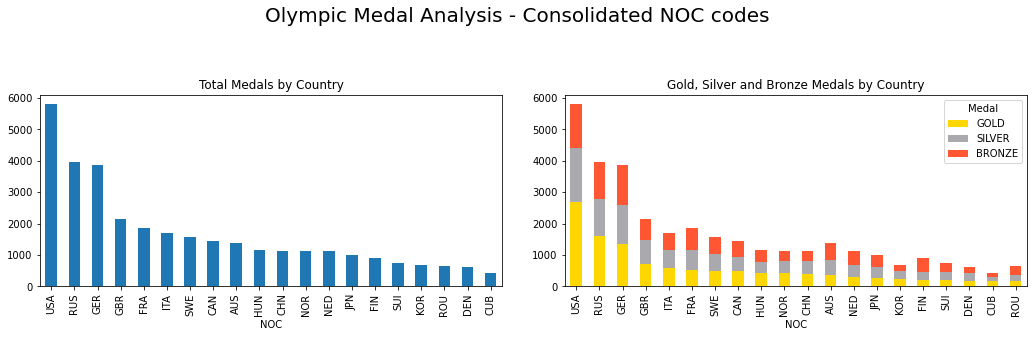

In [27]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharex=False)

fig.suptitle('Olympic Medal Analysis - Consolidated NOC codes', fontsize=20)

# Plot totals first with the updated NOCs
country_code_medals_totals_new.plot(ax=ax1, kind='bar', stacked=False, figsize=(15,5), title='Total Medals by Country',legend=False)

# Plot medals with updated NOCs
country_code_medals_ind_new.plot(ax=ax2, kind='bar', stacked=True, figsize=(15,5), title='Gold, Silver and Bronze Medals by Country', color=mcolors, legend=True)

# Space the plots out
fig.tight_layout(pad=3.0)

plt.show()

<b> INSIGHTS: </b>

By combining East and West Germany to one NOC code (GER) in the data-set, the data is much more representative. 
The overall medal counts for Germany increased significantly as did Russia. The overall medal tallies for these countries stack up more favourably than previously.
Russia ranks second overall and then closely followed by Germany.

### 3.2 Analysis by Year

The aim of this section is to highlight how the Olympics has changed year-on-year. 
Analysis is being based on the <b>top 8 countries</b>. This was to ensure that the graphs would be more readable. The data used in this section also applies the updated NOCs (e.g. it is the data set where East and West Germany have been merged)

In [28]:
# The first step is to create a list of the NOCs from the top 8 countries. 
# This filtered list will then be used for reporting

filter_NOCs = country_code_medals_totals_new.index.values
filter_NOCs = filter_NOCs[0:8]

#### 3.2.1 - Initial Year-by-Year Analysis

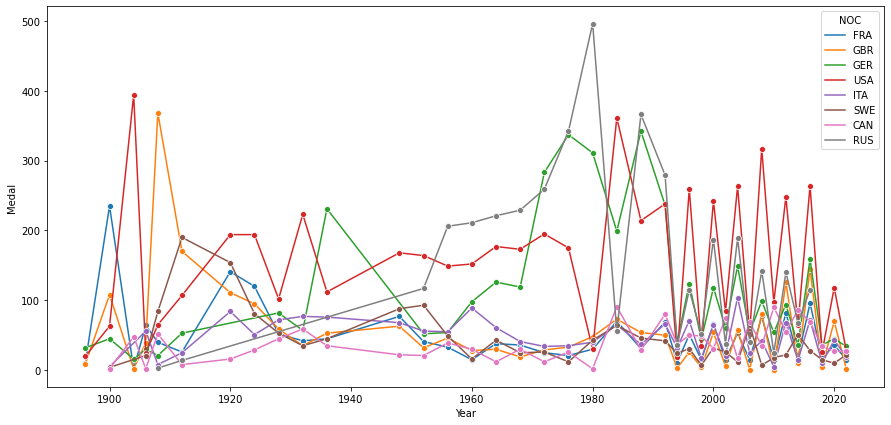

In [29]:
# Create dataframe containing counts of medals per country per year. Please
year_country_medals_totals = country_code_medals_updated_nocs.groupby(['Year','NOC'])['Medal'].count().reset_index()
year_country_medals_totals = year_country_medals_totals.sort_values(by = 'Year')
year_country_medals_totals = year_country_medals_totals[year_country_medals_totals.NOC.isin(filter_NOCs)]

fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot()
sns.lineplot(x='Year', y='Medal', hue='NOC', data=year_country_medals_totals, marker='o')
plt.show()

#### 3.2.2 - Initial Year-by-Year Analysis - Summer Only

The challenge with the plot above is that it includes both metrics from both Summer and Winter games in the data-set. The next section filters so that only summer data is used.

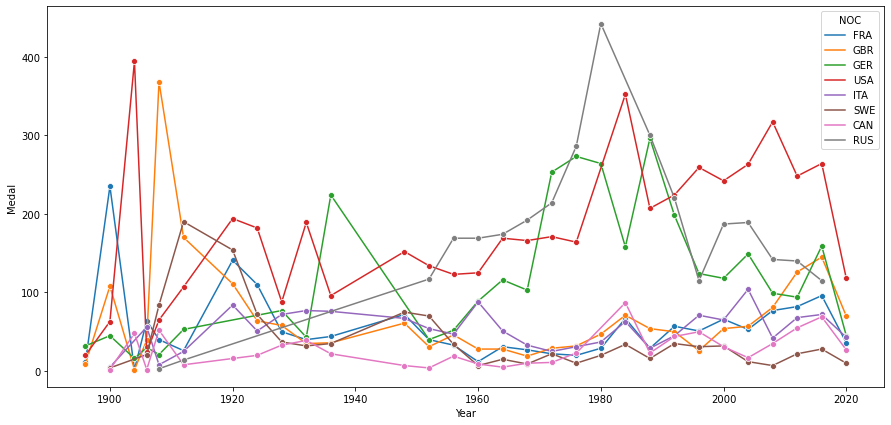

In [30]:
country_code_medals_updated_nocs_summer = country_code_medals_updated_nocs[country_code_medals_updated_nocs["Season"] == "Summer"]
year_country_medals_totals_summer = country_code_medals_updated_nocs_summer.groupby(['Year','NOC'])['Medal'].count().reset_index()
year_country_medals_totals_summer = year_country_medals_totals_summer.sort_values(by = 'Year')
year_country_medals_totals_summer = year_country_medals_totals_summer[year_country_medals_totals_summer.NOC.isin(filter_NOCs)]

fig = plt.figure(figsize = (15,7))
sns.lineplot(x='Year', y='Medal', hue='NOC', data=year_country_medals_totals_summer, marker='o')
plt.show()


<b>INSIGHTS:</b> The plot above is now much clearer now that the winter data has been removed. 

* As expected USA has continually performed well at the Summer Olympic Games. 
* GER (Germany) has been a consistent performer in the games. 
* GBR (Great Britain) and FRA (France) were successful nations during early games.
* History plays an important factor in some of this data. The USA boycotted the 1980 Olympics and Russia (RUS) boycotted the 1984 Olympics. This shows as peaks for respective nations during that timeframe. RUS spikes in 1980 and USA does in 1984
* FRA, SWE, ITA, and CAN have been fairly consistent in recent times

#### 3.2.3 - Analysis of Gender Participation - Summer Only

This next plot focuses on the gender of competing athletes over time. Please note that this is for Summer Olympic games only

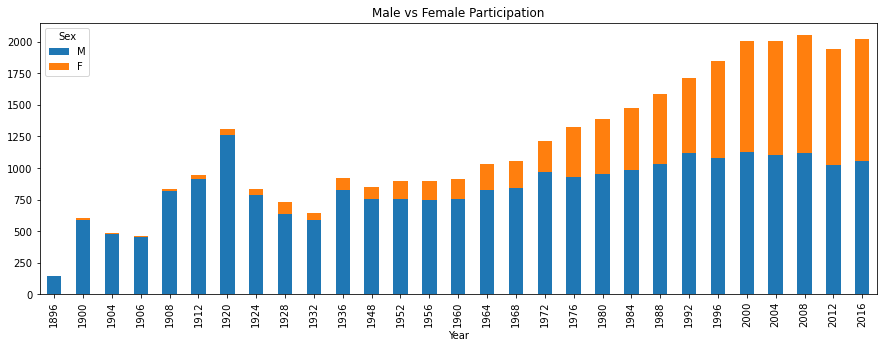

In [47]:
# Total up the number of male and female competitors by Year. This is for summer games only
country_code_years_gender = country_code_medals[country_code_medals["Season"]=="Summer"].groupby(['Year','Sex'])['Sex'].count().unstack().fillna(0)
country_code_years_gender = country_code_years_gender.sort_values(by=["Year"], ascending=True).head(29)
country_code_years_gender = country_code_years_gender[["M","F"]]

country_code_years_gender.plot(kind='bar', stacked=True, figsize=(15,5), title='Male vs Female Participation',legend=True)
plt.show()

<b>INSIGHTS:</b> 
    
Post World War 2, Female participation has been on the increase in the Summer Olympic games. There are similar trends in the Winter games.
Please note that 2020 data is not shown. Data only include final participant information.

#### 3.2.4 - Analysis by Year by Top 8 Country

This section profiles the total medals won for the Top 8 performing countries. 

The x-axis label also contains the NOC code for the host country. More on this later

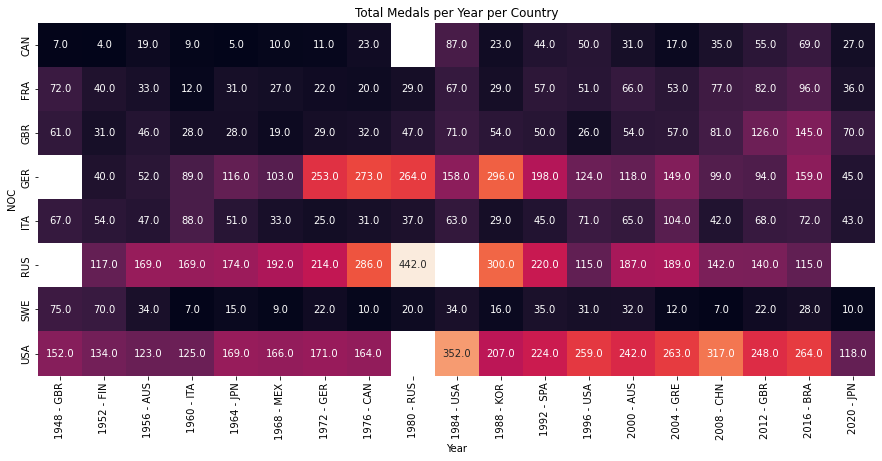

In [32]:
year_country_medals_totals_summer_heat = year_country_medals_totals_summer.copy()
year_country_medals_totals_summer_heat = year_country_medals_totals_summer_heat[year_country_medals_totals_summer_heat["Year"] > 1940]
year_country_medals_totals_summer_heat = year_country_medals_totals_summer_heat.pivot("NOC","Year","Medal")

host_cities_year_labels = ('1948 - GBR','1952 - FIN','1956 - AUS','1960 - ITA','1964 - JPN','1968 - MEX','1972 - GER','1976 - CAN','1980 - RUS',
                           '1984 - USA','1988 - KOR','1992 - SPA', '1996 - USA','2000 - AUS', '2004 - GRE', '2008 - CHN',
                           '2012 - GBR','2016 - BRA','2020 - JPN')

plt.figure(figsize=(15,10))
plt.title("Total Medals per Year per Country")
sns.heatmap(year_country_medals_totals_summer_heat, annot=True, cbar=False, fmt='', square=True, xticklabels=host_cities_year_labels)

plt.show()

<b>INSIGHT: </b>

* The heatmap above shows the total number of medals awarded at each Olympics since 1948. 
* The labels on the x axis have been changed to show the host country for that year e.g. 2012 GBR relates to London (GBR) hosting the 2012 Olympics.
* The aim of this plot is to determine if hosting the Olympics had a significant uplift in medals won.
* The data is showing this to be the case. If you consider GBR in 1948 and 2012, the total medal hauls were larger than ones in previous years. 2016 was a good year though as well. 
* The USA in 1984 won a staggering 352 medals. The USA count in 1996 is also particularly good
* Russia (RUS) count in 1980 is 442 but as well as hosting USA boycotted the event which may have led to an increase in medals

Whilst it is not conclusive it seems that hosting the Olympics does give the host nation a corresponding lift in terms of medals.

### 3.3 Athlete Analysis

#### 3.3.1 - Top Performers

The following section aims to profile the top Olympic performers of all time.

In [33]:
name_athlete_data_set = finalised_data_set.copy()
name_athlete_data_set = name_athlete_data_set[['Name','Sport','Medal']]
name_athlete_data_set = name_athlete_data_set.dropna().reset_index()
name_athlete_data_set = name_athlete_data_set.drop(name_athlete_data_set.columns[0],axis=1)

name_athlete_data_set = name_athlete_data_set.groupby(['Name','Sport','Medal'])['Medal'].count().unstack().fillna(0)

name_athlete_data_set = name_athlete_data_set[["GOLD","SILVER","BRONZE"]].sort_values(by=["GOLD"], ascending=False).head(15)

name_athlete_data_set = name_athlete_data_set.sort_values(by=["GOLD","SILVER","BRONZE"], ascending=True)

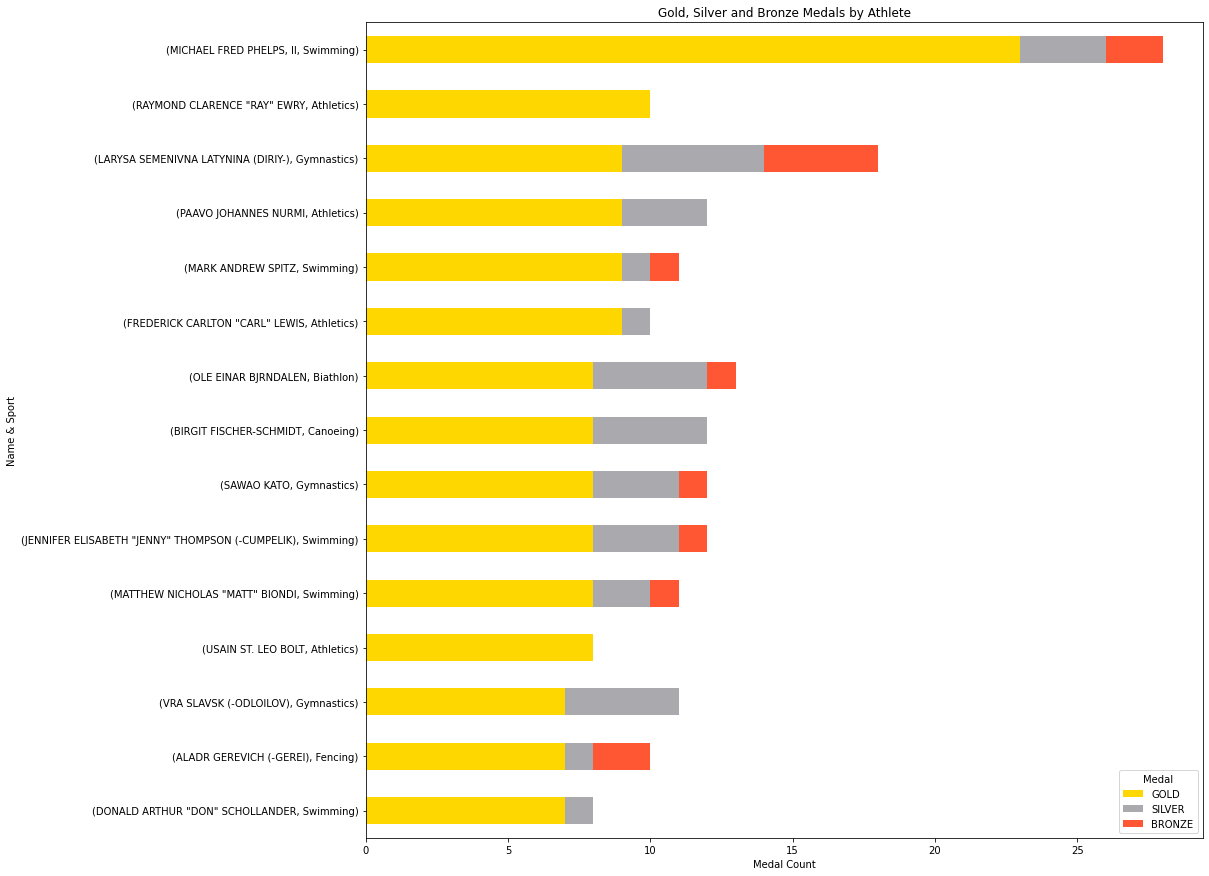

In [34]:
# Plot the top athlete data
name_athlete_data_set.plot(kind='barh', stacked=True, figsize=(15,15), title='Gold, Silver and Bronze Medals by Athlete', color=mcolors, legend=True)
plt.xlabel("Medal Count")
plt.ylabel("Name & Sport")
plt.show()

<b>INSIGHTS: </b>

* Michael Phelps is a clear leader in terms of overall medals won with a staggering 28 haul of which 23 were gold medals.
* In the top 15 athletes, the discipline of swimming makes up for a third (5) of the overall list. This could be down to the ability of swimmers to compete in a number of events across the same discipline.

#### 3.3.2 Athlete Characteristics - Age

The following section looks at specific athlete characteristics such as Age, Height, Weight and BMI (Body Mass Index)

In [35]:
## This function is used to search for Age data for specific athletes. 
## It queries Wikipedia based on the name of the Athlete and then extracts the age. 

def function_search_wikipedia_for_age(namestring):

    #This function takes in an athletes name and tries to search on wikipedia for that athletes
    base_url = 'https://en.wikipedia.org/wiki/'
    ageexp = re.compile("age[0-9][0-9]*")
    
    response = requests.get(base_url + namestring)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content,'html.parser')

        # This part of the function is used to capture bio elements from the wikipedia page
        output_dict = {}

        increment = 0
        for labels in soup.find_all(attrs={"class":"infobox-label"}):
            data = soup.find_all(attrs={"class":"infobox-data"})
            new_label = labels.get_text()
            output_dict[new_label] = data[increment].get_text().replace("\xa0","")
            increment += 1

        try:
            age_val = output_dict["Born"]
            age_val_list = ageexp.findall(age_val)
            if age_val_list:
                age_value = age_val_list[0]
                age_value = age_value[-2:]
            else:
                age_value = "AGE SEARCH ERROR"           
        
        except KeyError :
            age_value = "KEY ERROR"
    elif response.status_code == 404:
        age_value = "WIKI ERROR"

    return age_value


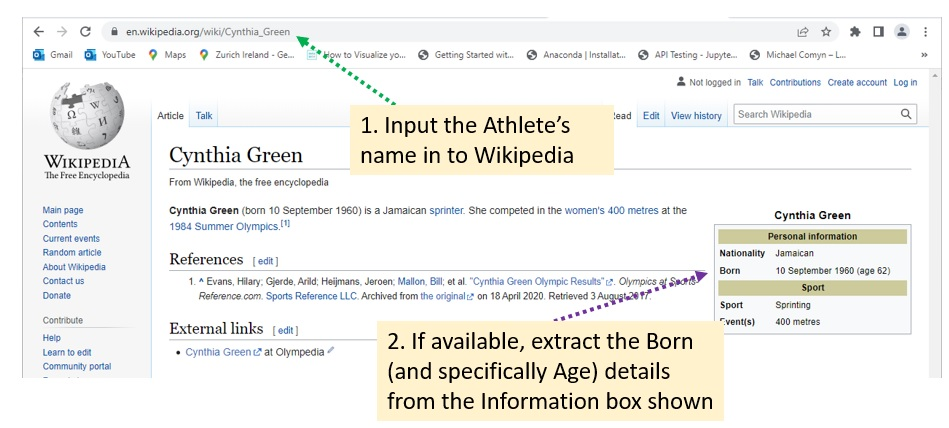

The image above, describes what the <b>function_search_wikipedia_for_age</b> does. 

The function does the following;

* 1. Makes an API call to Wikipedia using the specific Athlete's name passed in
* 2. If the search is valid it extracts the Born information from an Information Box that is located on the right-hand side of the Wikipedia search.
* 3. A regular expression is used to identify the current age. The fact that it is current is important and how this is handled is described below

In [36]:
## Extract specific data for Age, Height and Weight analysis
# Please note that we are only using data from 1984 onwards.

athletics_data_set = finalised_data_set[(finalised_data_set["Sport"] == "Athletics") & 
                                        (finalised_data_set["Year"] >= 1984) & 
                                        (finalised_data_set["Season"] == "Summer")]

athletics_data_set = athletics_data_set[['Name','Sex','Age','Year','Event','Height','Weight']]

##missing_values_count = athletics_data_set.isnull().sum()
##print("MISSING: \n", missing_values_count[0:7])

# There are about 130 records where the age is missing. 
# Web scraping has been used to capture some of this data to make the records more complete

# This is to ensure that wikipedia isn't called multiple times for the same athlete
previous_string = ""
update = 0

# Search through blank ages, retrieve the athlete name and then call the wiki search function to attempt to retreive the athlete age
for ind in athletics_data_set.index:
    
    # Search for values where that are not null
    if pd.isnull(athletics_data_set.loc[ind,"Age"]):
        
        # Retrieve the name details for the athlete thats age is not present
        name_string = athletics_data_set.loc[ind,"Name"]
          
        if((pd.notnull(name_string)) & (name_string != "nan")):
            
            #Split name by space. The aim is to get first and last name in the list
            names_arr = name_string.split(" ")
            first_name = names_arr[0].lower().capitalize()
            surname_val = names_arr[len(names_arr)-1].lower().capitalize()
            search_string = first_name + "_" + surname_val
            
            #print("SEARCH STRING", search_string)
            if (search_string != previous_string):
                ## Carry out web search
                age_value_wiki = function_search_wikipedia_for_age(search_string)
                
                previous_string = search_string
                if (age_value_wiki.find("ERROR") == -1):
                    # We have to calculate the age that the athlete was at the Olympics they attended.
                    # Calculation = Age - (Current Year - Olympic Year)
                    final_age = int(age_value_wiki) - (2022 - athletics_data_set.loc[ind,"Year"])
                    athletics_data_set.loc[ind,"Age"] = final_age
                    print("DETAILS: " + name_string + "- AGE: " + str(final_age) + "- PROCESSED AGE: " + age_value_wiki + " - RECORD NO: " + str(ind))
                    update += 1
            
            elif ((search_string == previous_string) & (age_value_wiki.find("ERROR") == -1)):
                # Athlete has already been checked. The Final Age should hold for this entry as well
                athletics_data_set.loc[ind,"Age"] = final_age
                print("DETAILS: " + name_string + "- AGE: " + str(final_age) + "- PROCESSED AGE: " + age_value_wiki + " - RECORD NO: " + str(ind)) 
                update += 1
                
print(str(update) + " - records were successfully updated.")

DETAILS: INNI ABOUBACAR- AGE: 39- PROCESSED AGE: 73 - RECORD NO: 852
DETAILS: ALASSANE BAH- AGE: 27- PROCESSED AGE: 61 - RECORD NO: 12509
DETAILS: ADDIS GEZAHEGN- AGE: 22- PROCESSED AGE: 52 - RECORD NO: 78634
DETAILS: NAGI GHAZI MOURSINE- AGE: 24- PROCESSED AGE: 58 - RECORD NO: 78705
DETAILS: CYNTHIA GREEN- AGE: 24- PROCESSED AGE: 62 - RECORD NO: 83858
DETAILS: CYNTHIA GREEN- AGE: 24- PROCESSED AGE: 62 - RECORD NO: 83859
DETAILS: ZEWDIE HAILEMARIAM- AGE: 30- PROCESSED AGE: 60 - RECORD NO: 88366
DETAILS: ABDURAHMAN JALLOW- AGE: 17- PROCESSED AGE: 55 - RECORD NO: 105677
DETAILS: MODUPE D. A. JONAH- AGE: 22- PROCESSED AGE: 56 - RECORD NO: 109939
DETAILS: HASSAN KARIMOU- AGE: 28- PROCESSED AGE: 62 - RECORD NO: 113626
DETAILS: STEPHEN LADO LUGOR- AGE: 24- PROCESSED AGE: 54 - RECORD NO: 143695
DETAILS: ABDOU MANZO- AGE: 28- PROCESSED AGE: 62 - RECORD NO: 148864
DETAILS: ABDOU MANZO- AGE: 28- PROCESSED AGE: 62 - RECORD NO: 148865
DETAILS: ABDOU MANZO- AGE: 28- PROCESSED AGE: 62 - RECORD NO: 1

In [37]:
## Post web-scraping, remove the remaining null data

#missing_values_count = athletics_data_set.isnull().sum()
#print("MISSING: \n", missing_values_count[0:7])

#Drop entries where there is no data
athletics_data_set = athletics_data_set.dropna().reset_index()

# Remove the column from the dataframe
athletics_data_set = athletics_data_set.drop(athletics_data_set.columns[0],axis=1)

##missing_values_count = athletics_data_set.isnull().sum()
##print("MISSING_2: \n",missing_values_count[0:8])


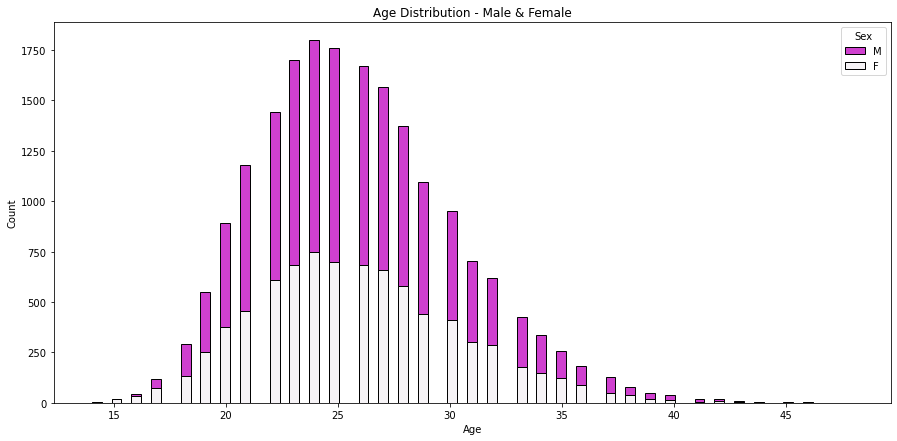

In [38]:
plt.figure(figsize = (15,7))
#sns.histplot(athletics_data_set,x="Age",hue="Sex",multiple="stack",palette="light:m_r",edgecolor="0.3",linewidth=1.0)
sns.histplot(athletics_data_set,x="Age",hue="Sex",multiple="stack",palette="light:m_r")
plt.title("Age Distribution - Male & Female")
plt.show()

<b>INSIGHT: </b> The Age Distribution is interesting but expected. The peak age for athletes is around 23 - 27 years old with 24 years being the main age for both Male and Female competitors. Please note that this is for Summer Olympics only and since 1984.
The data did indicate that early Olympics had much broader ages.

#### 3.3.3 Athlete Characteristics - Height & Weight

The following section looks at height and weight data specifically.

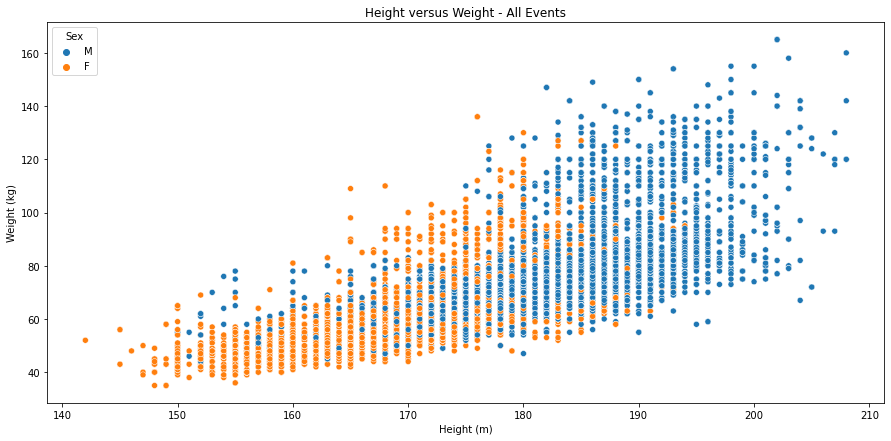

In [39]:
plt.figure(figsize = (15,7))
sns.scatterplot(x="Height",y="Weight",data=athletics_data_set,hue="Sex")
plt.title("Height versus Weight - All Events")
plt.ylabel("Weight (kg)")
plt.xlabel("Height (m)")
plt.show()

The scatterplot above shows height and weight differences across athletic events/disciplines. It is a good visual but does not tell us that much because the spread of data is extensive.

In [40]:
# Adjusting the data to show some specific events only
athletics_data_set_select = athletics_data_set[(athletics_data_set["Event"] == "Athletics Men's 20 kilometres Walk") | 
                                               (athletics_data_set["Event"] == "Athletics Men's Shot Put") | 
                                               (athletics_data_set["Event"] == "Athletics Men's High Jump")]


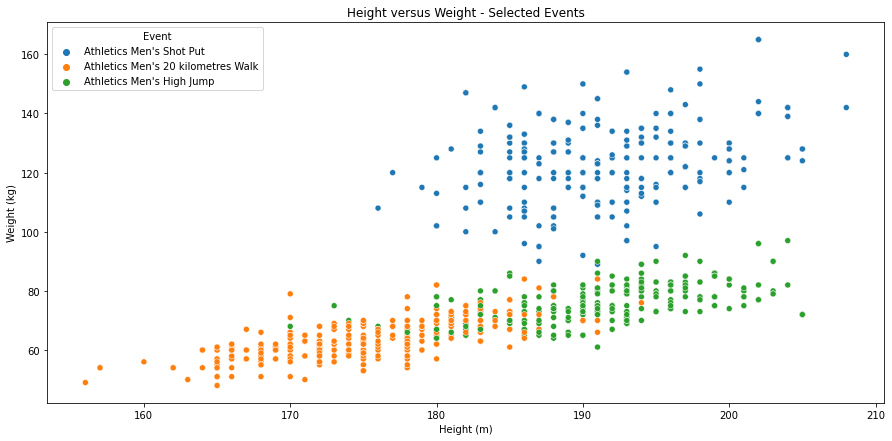

In [41]:
# Comparison between height/weight for specified events
plt.figure(figsize = (15,7))
sns.scatterplot(x="Height",y="Weight",data=athletics_data_set_select,hue="Event")
plt.title("Height versus Weight - Selected Events")
plt.ylabel("Weight (kg)")
plt.xlabel("Height (m)")
plt.show()


In [ ]:
<b>INSIGHT: </b>

When comparing the scatterplot across all athletic events, it was difficult to interpret the data.
Selecting different events and comparing makes it much simpler. In the graph above, the following insights can be determined;

* <b>Shot Putters</b> are generally tall and weigh more than the <b>High Jumpers</b> and <b>Walkers</b>
* <b>High Jumpers</b> are tall comparatively but have a narrower weight spectrum e.g. between 60 and 100 kg
* <b>Olympic Walkers</b> are generally shorter and lighter in terms of weight when compared to other disciplines

Essentially these differences in height and weight are what is required to excel in their specific athletic disciplines.

#### 3.3.4 Athlete Characteristics - BMI

In this section, BMI (Body Mass Index) is calculated and then analysed. BMI enables a comparison between someone's weight and their height. The definition is below;

<i>Body Mass Index (BMI) is a person’s weight in kilograms (or pounds) divided by the square of height in meters (or feet). A high BMI can indicate high body fatness. BMI screens for weight categories that may lead to health problems, but it does not diagnose the body fatness or health of an individual [1].</i>

The aim of performing analysis is to see the BMI calculations for Olympic Athletes.

In [42]:
# Create a data set specific to BMI calculation
athletics_data_set_bmi = athletics_data_set.copy()

# Calculate BMI
athletics_data_set_bmi['BMI'] = athletics_data_set_bmi.Weight / (athletics_data_set_bmi.Height/100) ** 2

#Note: The height values are in centimetres so the values need to be divided by 100 to get metres

In [43]:
# Filter on specific information. We focus in on female competitors
athletics_data_set_bmi = athletics_data_set_bmi[["Event","Sex","Age","Height","Weight","BMI"]]
athletics_data_set_bmi = athletics_data_set_bmi[athletics_data_set_bmi["Sex"] == "F"]
athletics_data_set_bmi = athletics_data_set_bmi.reset_index()

# Remove index
athletics_data_set_bmi = athletics_data_set_bmi.drop(athletics_data_set_bmi.columns[0],axis=1)

# Remove gender column as its not needed
athletics_data_set_bmi = athletics_data_set_bmi.drop(["Sex"],axis=1)

# Map to specific events to make the plot simpler to filter and read
event_mapping = {
    'Athletics Women\'s Javelin Throw':'Throw: Javelin', 'Athletics Women\'s Marathon':'Marathon',
    'Athletics Women\'s 3,000 metres':'3000 metres', 'Athletics Women\'s 100 metres':'100 metres',
    'Athletics Women\'s 200 metres':'200 metres', 'Athletics Women\'s 800 metres':'800 metres',
    'Athletics Women\'s Long Jump':'Jump: Long Jump', 'Athletics Women\'s 5,000 metres':'5000 metres',
    'Athletics Women\'s 10,000 metres':'10000 metres', 'Athletics Women\'s 4 x 100 metres Relay':'Relay: 4 x 100 metres',
    'Athletics Women\'s 1,500 metres':'1500 metres', 'Athletics Women\'s 4 x 400 metres Relay':'Relay: 4 x 400 metres',
    'Athletics Women\'s Shot Put':'Throw: Shot Put', 'Athletics Women\'s 400 metres':'400 metres',
    'Athletics Women\'s 400 metres Hurdles':'400 metres Hurdles', 'Athletics Women\'s High Jump':'Jump: High Jump',
    'Athletics Women\'s 100 metres Hurdles':'100 metres Hurdles', 'Athletics Women\'s Discus Throw':'Throw: Discus Throw',
    'Athletics Women\'s Heptathlon':'Heptathlon', 'Athletics Women\'s 3,000 metres Steeplechase':'3000 metres Steeplechase',
    'Athletics Women\'s 20 kilometres Walk':'20000 Walk', 'Athletics Women\'s Triple Jump':'Jump: Triple Jump',
    'Athletics Women\'s Hammer Throw':'Throw: Hammer Throw', 'Athletics Women\'s 10 kilometres Walk':'10000 Walk',
    'Athletics Women\'s Pole Vault':'Pole Vault'
}

athletics_data_set_bmi['Event'] = athletics_data_set_bmi['Event'].replace(event_mapping)

# Sort data by events to help the visual
athletics_data_set_bmi = athletics_data_set_bmi.sort_values(by=["Event"], ascending=True)

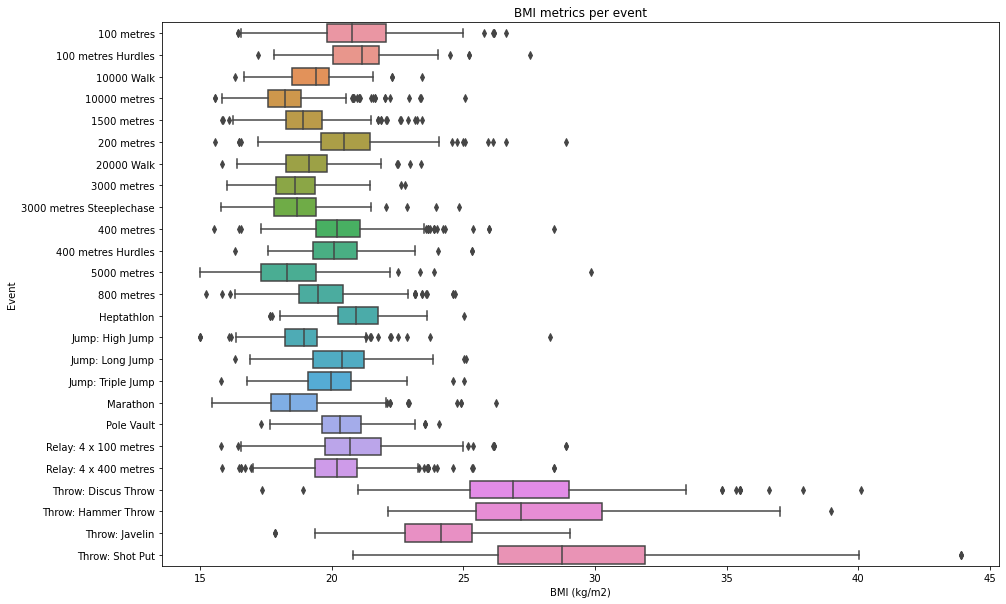

In [44]:
# Plot BMI versus event information.
plt.figure(figsize=(15,10))
plt.title("BMI metrics per event")
sns.boxplot(data=athletics_data_set_bmi, x="BMI",y="Event")
plt.xlabel("BMI (kg/m2)")
plt.show()

<b>INSIGHTS: </b>

The data shown in the graph above is interesting.

* The sprinting events seem to have similar BMI ranges and based on the table below, would be classified as within the <b>normal</b> range.
* Long distance events (5k, 10k, 20k walk, marathon) have similar BMI ranges. The table indicates that some of these would be approaching <b>underweight</b> status. Hindsight would tell us that athletes performing at these distances need to manage their weight extensively.
* The throwing disciplines are then at the complete opposite end of the spectrum. Hammer, Discuss, and Shot Put competitors have much higher BMI ranges and would be within <b>overweight</b> and sometimes <b>obese</b> classifications based on the table.
* Javelin throwers occupy a lower range than the other throwing categories. This does seem logical given the running and throwing nature of the event

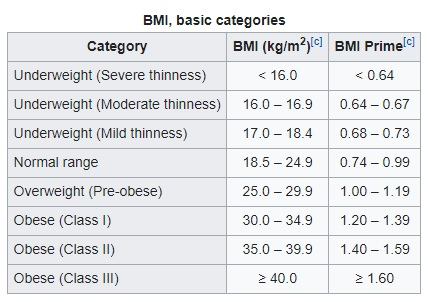

### 4. Insights

This is a collection of all the insights sections above.

<b>Medal Analysis</b>

* The USA is ahead in terms of total medal haul across Summer and Winter games. Once the NOC updates were performed, Russia and German tallies increased further. This resulted in the gap between USA and the next nearest countries being smaller.
* Canada (CAN) performs well at both Summer and Winter games. It’s worth noting that they are evenly matched with the USA in terms of overall Winter medals achieved.

<b>Year-by-year</b>

* As expected USA has continually performed well at the Summer Olympic Games. GER (Germany) has also been a consistent performer in the games. History plays an important factor in some of this data. The USA boycotted the 1980 Olympics and Russia (RUS) boycotted the 1984 Olympics. The data shows as peaks for respective nations during that timeframe. RUS spikes in 1980 and USA does in 1984. FRA, SWE, ITA, and CAN have been fairly consistent in recent times.
* From 1948 onwards, female participation has been on the increase in the Summer Olympic games. This trend is repeated in Winter games. 

<b>Medal Totals Heatmap</b>

* The data indicates that hosting the Olympics does give that specific nation a corresponding lift in terms of medals. For example with GBR in 1948 and 2012, the total medal hauls were larger than ones in previous years. There are anomalies in the data such as 1980 and 1984 when the boycotts led to more medals being won.

<b>Top Performers</b>

* Michael Phelps is a clear leader in terms of overall medals won with a staggering 28 haul of which 23 were gold medals. In the top 15 athletes, the discipline of swimming makes up for a third (5) of the overall list. This could be down to the ability of swimmers to compete in a number of events across the same discipline.

<b>Age Analysis</b>

* The peak age for athletes is around 23 - 27 years old with 24 years being the main age for both Male and Female competitors. Please note that this is for Summer Olympics only and since 1984. The data did indicate that early Olympics had much broader ages.

<b> Height and Weight Analysis</b>

* When comparing the scatterplot data across all athletic events, it was difficult to interpret the result. Selecting different events and comparing makes it much simpler. 
* Shot Putters are generally tall and weigh more than the High Jumpers and Walkers
* High Jumpers are tall comparatively but have a narrower weight spectrum e.g. between 60 and 100 kg
* Olympic Walkers are generally shorter and lighter in terms of weight when compared to other disciplines

<b>BMI Analysis</b>

* The sprinting events seem to have similar BMI ranges and would be classified as within the normal BMI range.
* Long distance events (5k, 10k, 20k walk, marathon) have similar BMI ranges, however, it seems that some of these would be approaching underweight status. Hindsight would tell us though that athletes performing at these distances need to manage their weight extensively.
* The throwing disciplines are then at the complete opposite end of the spectrum. Hammer, Discuss, and Shot Put competitors have much higher BMI ranges and would be within overweight and sometimes obese classifications based on the table.
* Javelin throwers occupy a lower range than the other throwing categories. This does seem logical given the running and throwing nature of the event.
